# Contrastive Learning


We will explore contrastive learning, and more specifically cosine similarity and the InfoNCE loss, the loss function used in [SimCLR](https://arxiv.org/abs/2002.05709).

There will be three main tasks:
* Extract embeddings from a pre-trained image encoder
* Implement and analyse cosine similarities on a set of images.
* Implement the infoNCE loss on a particular loss and investigate the effect of the temperature parameter.

**Objective:** Implement key parts of the SimCLR self-supervised learning strategy.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms

## Data

Let's donwload some test images

In [2]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/simclr.zip
! unzip simclr.zip

--2025-02-04 12:05:48--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/simclr.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3537164 (3.4M) [application/zip]
Saving to: ‘simclr.zip’

simclr.zip          100%[===================>]   3.37M  12.4MB/s    in 0.3s    

2025-02-04 12:05:49 (12.4 MB/s) - ‘simclr.zip’ saved [3537164/3537164]

Archive:  simclr.zip
   creating: data/simclr/
  inflating: data/simclr/imagenet1000_clsidx_to_labels.txt  
   creating: data/simclr/test_images/
  inflating: data/simclr/test_images/image_0.jpg  
  inflating: data/simclr/test_images/image_1.jpg  
  inflating: data/simclr/test_images/image_2.jpg  
  inflating: data/simclr/test_images/image_3.jpg  
  inflating: data/simclr/test_images/image_4.jpg  
  inflating: data/simclr/test_images/image_5.jpg  
  inflating: data/simclr/test_images/image_6.jpg  
  i

Let's look at the images available to us for this tutorial:

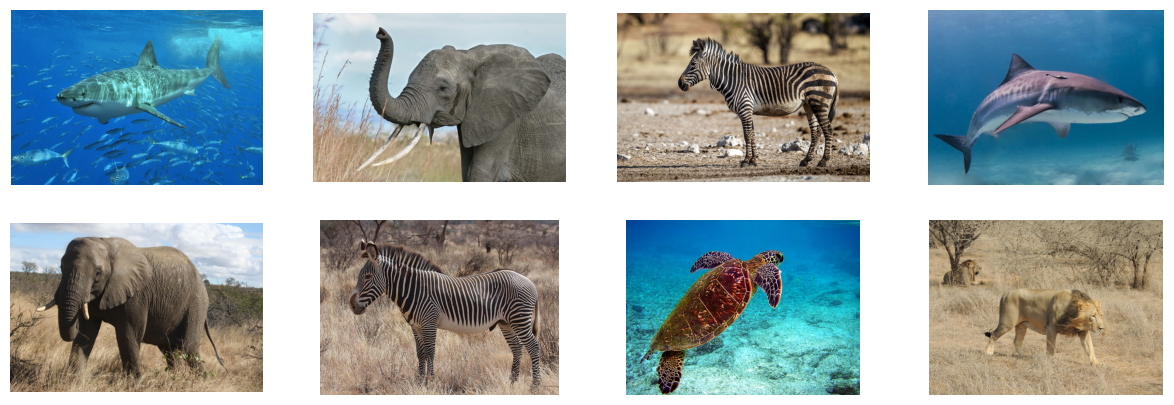

In [3]:
f, ax = plt.subplots(2,4,figsize=(15,5))
ax = ax.ravel()

for i in range(8):
  image = cv2.cvtColor(cv2.imread('./data/simclr/test_images/image_' + str(i) + '.jpg'), cv2.COLOR_BGR2RGB)
  ax[i].imshow(image)
  ax[i].axis('off')

## Extract embeddings from pretrained ResNet model

In this tutorial, we will be using a [ResNet-18](https://arxiv.org/abs/1512.03385) model pretrained on ImageNet data to extract the image embeddings and illustrate the behaviour of our InfoNCE loss function.

**Step 1 (TASK):** Given the following model class, implement the function `get_embeddings` that retrieves the embeddings of the last layer.

In [8]:
from torchvision.models import resnet18, ResNet18_Weights
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        # Get the pretrained resnet network
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x

    def get_embeddings(self, x):
        # TODO: Write a function that just returns the last layer embeddings.
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        return x

**Step 2:** Create dataloader to load our test images.

Note: we need to use a normalisation transform in the pre-processing to match the pre-processing used during model pretraining.

In [12]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg16
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define the image dataset
dataset = datasets.ImageFolder(root='./data/simclr/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=8)

# ImageNet class names
with open('./data/simclr/imagenet1000_clsidx_to_labels.txt') as f:
    idx2label = eval(f.read())

**Step 3 (TASK):** Create and test the model

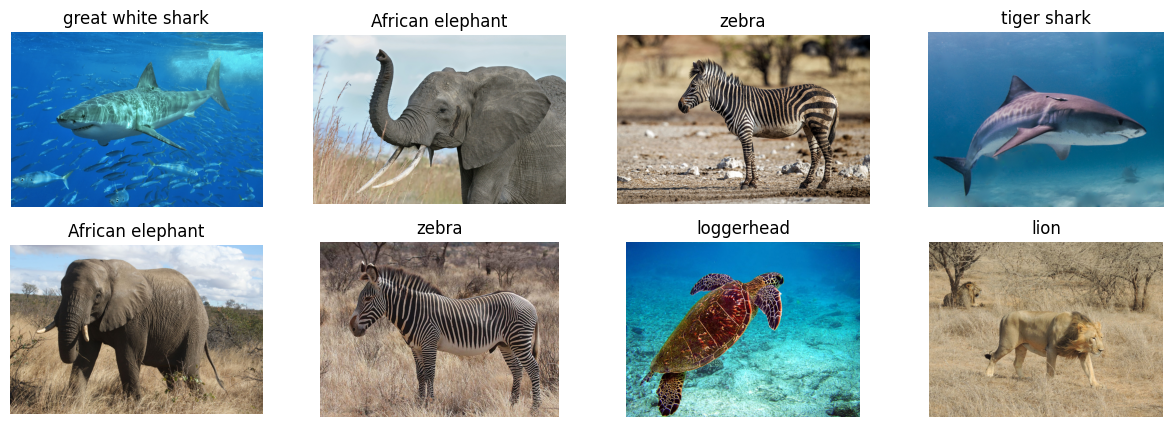

In [14]:
# initialize the ResNet model
resnet = ResNet18()

# set the evaluation mode
resnet.eval()

# get a batch from the dataloader
batch_images, _ = next(iter(dataloader))

# TODO: get the most likely prediction of the model
logits = resnet(batch_images)

predicted_label = torch.argmax(logits, dim=1)

# Convert class ids to class names
predicted_classes = [idx2label[pred.item()].split(',')[0] for pred in predicted_label]

# visualise
f, ax = plt.subplots(2,4,figsize=(15,5))
ax = ax.ravel()

for i in range(8):
  image = cv2.cvtColor(cv2.imread('./data/simclr/test_images/image_' + str(i) + '.jpg'), cv2.COLOR_BGR2RGB)
  ax[i].set_title(predicted_classes[i])
  ax[i].imshow(image)
  ax[i].axis('off')

**Step 4 (TASK):** Let's gather the embeddings for our batch of test images

In [15]:
## TODO: Get the embeddings for the batch of test images
with torch.no_grad():
  embeddings = resnet.get_embeddings(batch_images)

## Computation of cosine similarity

In this part, the goal is to implement the cosine similarity function as seen in the lecture

$$sim(u,v) = \frac{u^Tv}{||u||\cdot||v||}$$

**Step 1 (TASK):** function definition

In [24]:
def cosine_similarity(u, v):
  ## TODO: fill in the blanks here
  return torch.dot(u, v) / (torch.linalg.norm(u) * torch.linalg.norm(v))

Let's compute the similarity between the embeddings of image_0 and image_1.

In [25]:
cosine_similarity(embeddings[0], embeddings[1])

tensor(0.4627)

Let's check that we get the same result than with the built-in cosine similarity function:

In [26]:
assert torch.isclose(torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1], dim=-1), cosine_similarity(embeddings[0], embeddings[1]))

**Step 2 (TASK):** Analyse cosine similarities across all images in the batch.

Now let's create a heatmap containing all the pair-wise similarities. Precisely each element in the `similarity_matrix[i,j]` should contain the similarity between image_i and image_j

In [29]:
# TODO: create the matrix of similarities
similarity_matrix = torch.Tensor([[cosine_similarity(embeddings[i], embeddings[j]) for i in range(batch_images.shape[0])] for j in range(batch_images.shape[0])])

Let's plot this similarity matrix as a heatmap.

<Axes: >

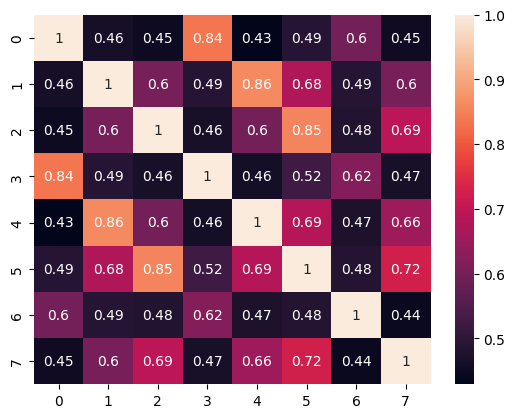

In [30]:
sns.heatmap(similarity_matrix, annot=True)

**TASK:** Let's look at which pairs of images have the highest and lowest similarities.

[(1, 4), (2, 5), (0, 3)]


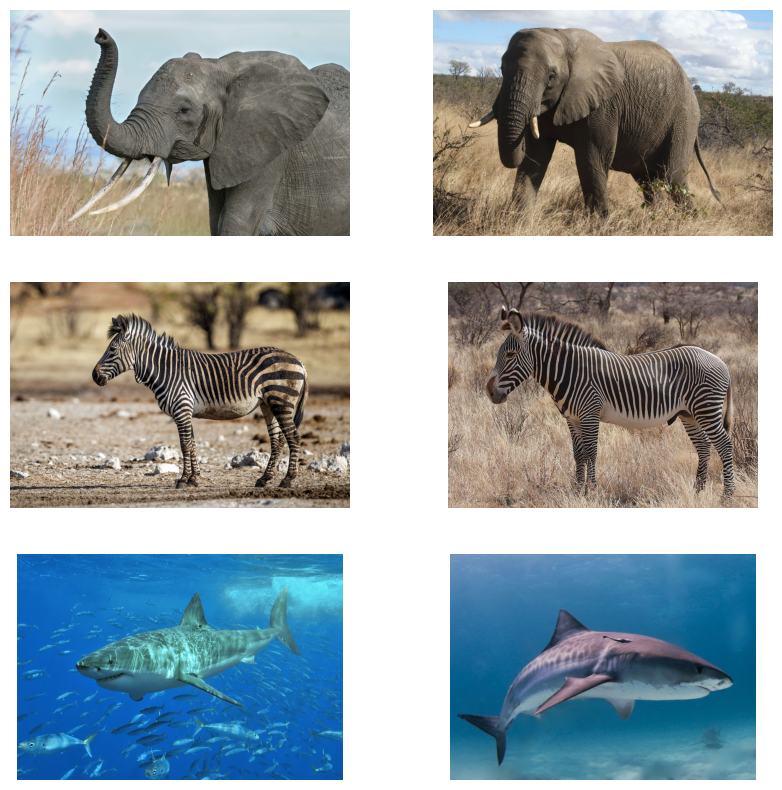

In [47]:
## TODO: find the 3 pairs of images with the highest
## similarity score:
# top_image_pairs = [(i,j), (k,l), (m,n)]

upper_triangular = torch.triu(similarity_matrix, diagonal=1)
# Get the (i, j) pairs and their similarity scores
pairs_with_scores = []
for i in range(upper_triangular.shape[0]):
    for j in range(i + 1, upper_triangular.shape[1]):  # Only upper triangle
        pairs_with_scores.append(((i, j), upper_triangular[i, j].item()))

# Sort pairs based on similarity score (highest first)
top_image_pairs = sorted(pairs_with_scores, key=lambda x: x[1], reverse=True)[:3]
top_image_pairs = [pair[0] for pair in top_image_pairs]
print(top_image_pairs)

# Visualise these pairs
f, ax = plt.subplots(3, 2,figsize=(10,10))
for i, pair in enumerate(top_image_pairs):
  image = cv2.cvtColor(cv2.imread('./data/simclr/test_images/image_' + str(pair[0]) + '.jpg'), cv2.COLOR_BGR2RGB)
  ax[i, 0].imshow(image)
  ax[i, 0].axis('off')
  image = cv2.cvtColor(cv2.imread('./data/simclr/test_images/image_' + str(pair[1]) + '.jpg'), cv2.COLOR_BGR2RGB)
  ax[i, 1].imshow(image)
  ax[i, 1].axis('off')

Let's repeat with the lowest similarity:

[(0, 4), (6, 7), (0, 2)]


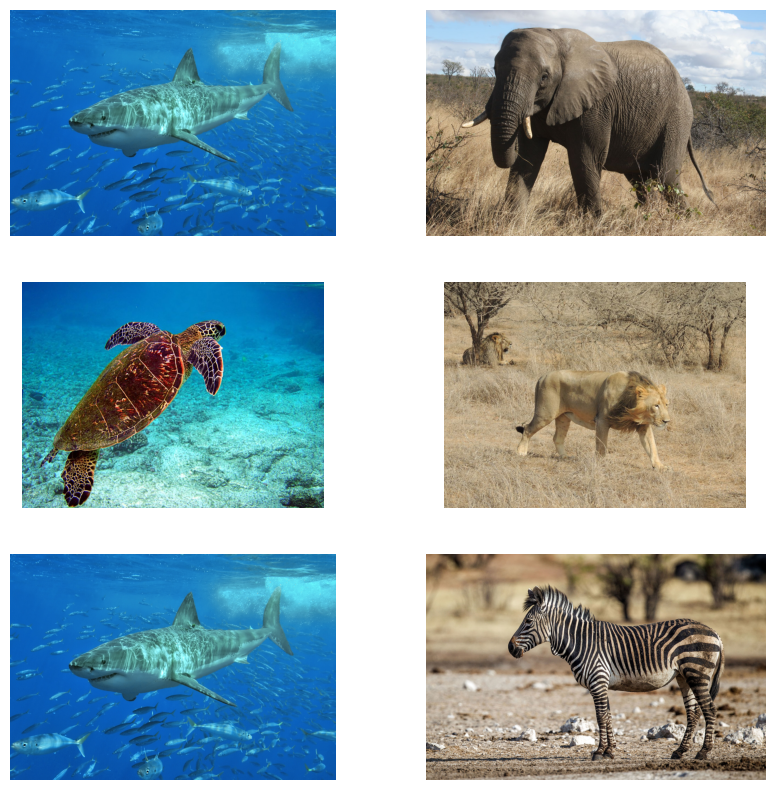

In [51]:
## TODO: find the 3 pairs of images with the lowest
## similarity score:
## TODO  bad_image_pairs = [(i,j), (k,l), (m,n)]

upper_triangular = torch.triu(similarity_matrix, diagonal=1)
# Get the (i, j) pairs and their similarity scores
pairs_with_scores = []
for i in range(upper_triangular.shape[0]):
    for j in range(i + 1, upper_triangular.shape[1]):  # Only upper triangle
        pairs_with_scores.append(((i, j), upper_triangular[i, j].item()))

# Sort pairs based on similarity score (highest first)
bad_image_pairs = sorted(pairs_with_scores, key=lambda x: x[1], reverse=False)[:3] # Cambiar a False
bad_image_pairs = [pair[0] for pair in bad_image_pairs]
print(bad_image_pairs)


# Visualise
f, ax = plt.subplots(3,2,figsize=(10,10))
for i, pair in enumerate(bad_image_pairs):
  image = cv2.cvtColor(cv2.imread('./data/simclr/test_images/image_' + str(pair[0]) + '.jpg'), cv2.COLOR_BGR2RGB)
  ax[i, 0].imshow(image)
  ax[i, 0].axis('off')
  image = cv2.cvtColor(cv2.imread('./data/simclr/test_images/image_' + str(pair[1]) + '.jpg'), cv2.COLOR_BGR2RGB)
  ax[i, 1].imshow(image)
  ax[i, 1].axis('off')

Do these pairs make sense? Are the embeddings of the pretrained ResNet well capturing the semantic information present in the images?
It seems it is just capturing if the animal is in the water or not.

## InfoNCE loss computation

Next, we'd like to create a function that returns the loss for each pair "positive" pair of images.

As a reminder the infoNCE loss looks like this:

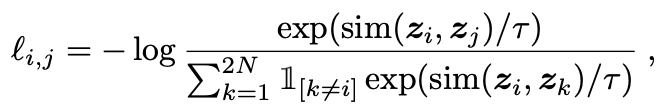

With i,j the positive pairs and the denominator summing over all other terms in the batch.

Here we assume that our positive pairs are [(0,3), (1,4), (2,5)], and all other images form the negative pairs. We here assume we have 8 iamges in our batch.

**TASK:** For a given pair of indices (i,j) implement a function that returns the loss as per the equation above, the function should take the pre-computed similarity matrix as well as the temperature as arguments.

In [56]:
print(top_image_pairs)

[(1, 4), (2, 5), (0, 3)]


In [52]:
def get_infoNCE_loss(i, j, similarity_matrix, temperature = 1.0):
  ## TODO: implement the loss function
  return -torch.log(torch.exp(similarity_matrix[i,j]/temperature) / torch.sum(torch.exp(similarity_matrix[i,:]/temperature)))

In [53]:
for i, j in top_image_pairs:
  print(get_infoNCE_loss(i, j, similarity_matrix))

tensor(1.8834)
tensor(1.8849)
tensor(1.8543)


Next, we'd like to test the effect of the temperature parameter on the loss function. Run the following cells and compare the loss values as we lower or increase the temperature.


In [54]:
for i, j in top_image_pairs:
  print(get_infoNCE_loss(i, j, similarity_matrix, temperature=0.1))

tensor(1.6915)
tensor(1.7371)
tensor(1.8566)


In [55]:
for i, j in top_image_pairs:
  print(get_infoNCE_loss(i, j, similarity_matrix, temperature=10))

tensor(2.0583)
tensor(2.0584)
tensor(2.0550)


**TASK:** What's the effect of the temperature change?

Higher temperature higher loss and viceversa ??? check this

Lower temp higher distance between different classes, higher there's not much difference